# INTRODUCTION

In the dynamic and ever-evolving landscape of the telecommunications industry, customer churn has become a critical challenge for service providers. The ability to predict and understand customer churn can significantly impact business success, customer retention strategies, and ultimately, the bottom line. 
In this project, we embark on an exciting journey to explore and analyze customer churn within the Vodafone network service using the CRISP-DM (Cross-Industry Standard Process for Data Mining) framework. 
Our aim is to leverage data-driven insights to identify key factors influencing churn, build predictive models, and develop actionable recommendations that can help Vodafone proactively retain valuable customers and enhance their overall service offerings.

# BUSINESS UNDERSTANDING

In the dynamic and ever-evolving landscape of the telecommunications industry, customer churn has become a critical challenge for service providers. The ability to predict and understand customer churn can significantly impact business success, customer retention strategies, and ultimately, the bottom line. 

In this project, we embark on an exciting journey to explore and analyze customer churn within the Vodafone network service using the CRISP-DM (Cross-Industry Standard Process for Data Mining) framework. Our aim is to leverage data-driven insights to identify key factors influencing churn, build predictive models, and develop actionable recommendations that can help Vodafone proactively retain valuable customers and enhance their overall service offerings.

# IMPORTATION

In [1]:
# Import necessary libraries

# Connect to server
import pyodbc
from dotenv import dotenv_values

# Data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

# Correlation
import phik

# Visualize missing values
import missingno as msno

# Hypothesis testing
import scipy.stats as stats

#Impute
from sklearn.impute import SimpleImputer

# Machine Learning
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

# Class Imbalance
from imblearn.over_sampling import SMOTE

# Model interpretability
from lime.lime_tabular import LimeTabularExplainer

import warnings

# ignore warnings
warnings.filterwarnings('ignore')

# DATA LOADING

Create a .env file in root of the folder of the project and all the sensitive information in the .env file

In [2]:
# Load environment variables from a .env file
env_variables = dotenv_values('../.env')

server= env_variables.get('SERVER')
database= env_variables.get('DATABASE')
username= env_variables.get('USERNAME')
password= env_variables.get('PASSWORD')

Create a .gitignore file and type '/.env/' file we just created. This will prevent git from tracking the file.

Create a connection by accessing your connection string with your defined environment variables 

In [3]:
# Setup connection string to connect to the remote server
connection_string = pyodbc.connect(f'DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}')

Setup the links and queries to read the data from the various sources

In [4]:
# Query statement to fetch the first 3000 data from the remote server
telco_churn_3000_query = 'SELECT * FROM dbo.LP2_Telco_churn_first_3000'

# Get link to the third data hosted on github
telco_churn_last2000_url = "https://raw.githubusercontent.com/Azubi-Africa/Career_Accelerator_LP2-Classifcation/main/LP2_Telco-churn-last-2000.csv"

In [5]:
# Read all data from different sources
df_first_3000 = pd.read_sql_query(telco_churn_3000_query, connection_string)
df_second_2000 = pd.read_excel('Telco-churn-second-2000.xlsx')
df_last_2000 = pd.read_csv(telco_churn_last2000_url)

# DATA UNDERSTANDING

The dataset contains customer information from the Vodafone network service, including features like MonthlyCharges, Tenure, SeniorCitizen status, and various service subscriptions (e.g., OnlineSecurity, OnlineBackup). The target variable 'Churn' indicates whether a customer has churned ('Yes') or not ('No'). Before building the models, we need to preprocess the data, handle missing values, and address class imbalance.

| Feature           | Description                                                          |
|-----------------|----------------------------------------------------------------------|
| Gender          | Whether the customer is a male or a female                          |
| SeniorCitizen   | Whether a customer is a senior citizen or not                       |
| Partner         | Whether the customer has a partner or not (Yes, No)                 |
| Dependents      | Whether the customer has dependents or not (Yes, No)                |
| Tenure          | Number of months the customer has stayed with the company           |
| Phone Service   | Whether the customer has a phone service or not (Yes, No)           |
| MultipleLines   | Whether the customer has multiple lines or not                      |
| InternetService | Customer's internet service provider (DSL, Fiber Optic, No)        |
| OnlineSecurity  | Whether the customer has online security or not (Yes, No, No Internet) |
| OnlineBackup    | Whether the customer has online backup or not (Yes, No, No Internet) |
| DeviceProtection| Whether the customer has device protection or not (Yes, No, No internet service) |
| TechSupport     | Whether the customer has tech support or not (Yes, No, No internet) |
| StreamingTV     | Whether the customer has streaming TV or not (Yes, No, No internet service) |
| StreamingMovies | Whether the customer has streaming movies or not (Yes, No, No Internet service) |
| Contract        | The contract term of the customer (Month-to-Month, One year, Two year) |
| PaperlessBilling| Whether the customer has paperless billing or not (Yes, No)        |
| Payment Method  | The customer's payment method (Electronic check, mailed check, Bank transfer(automatic), Credit card(automatic)) |
| MonthlyCharges  | The amount charged to the customer monthly                         |
| TotalCharges    | The total amount charged to the customer                            |
| Churn           | Whether the customer churned or not (Yes or No)                     |


# EXPLORATORY DATA ANALYSIS (EDA)

Use various pandas methods to get preliminary information about the various datasets

In [6]:
# View the 5 first rows of the first 3000 data points
df_first_3000.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,False,True,False,1,False,None,DSL,False,...,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.850000,False
1,5575-GNVDE,Male,False,False,False,34,True,False,DSL,True,...,True,False,False,False,One year,False,Mailed check,56.950001,1889.500000,False
2,3668-QPYBK,Male,False,False,False,2,True,False,DSL,True,...,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002,True
3,7795-CFOCW,Male,False,False,False,45,False,None,DSL,True,...,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.750000,False
4,9237-HQITU,Female,False,False,False,2,True,False,Fiber optic,False,...,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.649994,True


In [7]:
# View the first 5 rows of the second 2000 data points
df_second_2000.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7613-LLQFO,Male,0,No,No,12,Yes,Yes,Fiber optic,No,No,No,No,Yes,No,Month-to-month,Yes,Electronic check,84.45,1059.55
1,4568-TTZRT,Male,0,No,No,9,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.40,181.8
2,9513-DXHDA,Male,0,No,No,27,Yes,No,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,No,Electronic check,81.70,2212.55
3,2640-PMGFL,Male,0,No,Yes,27,Yes,Yes,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,79.50,2180.55
4,3801-HMYNL,Male,0,Yes,Yes,1,Yes,No,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,No,Mailed check,89.15,89.15


In [8]:
# View the first 5 rows of the last 2000 data points
df_last_2000.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,5600-PDUJF,Male,0,No,No,6,Yes,No,DSL,No,...,No,Yes,No,No,Month-to-month,Yes,Credit card (automatic),49.50,312.7,No
1,8292-TYSPY,Male,0,No,No,19,Yes,No,DSL,No,...,Yes,Yes,No,No,Month-to-month,Yes,Credit card (automatic),55.00,1046.5,Yes
2,0567-XRHCU,Female,0,Yes,Yes,69,No,No phone service,DSL,Yes,...,Yes,No,No,Yes,Two year,Yes,Credit card (automatic),43.95,2960.1,No
3,1867-BDVFH,Male,0,Yes,Yes,11,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,74.35,834.2,Yes
4,2067-QYTCF,Female,0,Yes,No,64,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,111.15,6953.4,No


In [9]:
# Check the number of columns and rows in each data
df_first_3000.shape, df_second_2000.shape, df_last_2000.shape

((3000, 21), (2000, 20), (2043, 21))

In [10]:
# Get more information about the columns and their data types
df_first_3000.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        3000 non-null   object 
 1   gender            3000 non-null   object 
 2   SeniorCitizen     3000 non-null   bool   
 3   Partner           3000 non-null   bool   
 4   Dependents        3000 non-null   bool   
 5   tenure            3000 non-null   int64  
 6   PhoneService      3000 non-null   bool   
 7   MultipleLines     2731 non-null   object 
 8   InternetService   3000 non-null   object 
 9   OnlineSecurity    2349 non-null   object 
 10  OnlineBackup      2349 non-null   object 
 11  DeviceProtection  2349 non-null   object 
 12  TechSupport       2349 non-null   object 
 13  StreamingTV       2349 non-null   object 
 14  StreamingMovies   2349 non-null   object 
 15  Contract          3000 non-null   object 
 16  PaperlessBilling  3000 non-null   bool   


In [11]:
# second dataset
df_second_2000.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        2000 non-null   object 
 1   gender            2000 non-null   object 
 2   SeniorCitizen     2000 non-null   int64  
 3   Partner           2000 non-null   object 
 4   Dependents        2000 non-null   object 
 5   tenure            2000 non-null   int64  
 6   PhoneService      2000 non-null   object 
 7   MultipleLines     2000 non-null   object 
 8   InternetService   2000 non-null   object 
 9   OnlineSecurity    2000 non-null   object 
 10  OnlineBackup      2000 non-null   object 
 11  DeviceProtection  2000 non-null   object 
 12  TechSupport       2000 non-null   object 
 13  StreamingTV       2000 non-null   object 
 14  StreamingMovies   2000 non-null   object 
 15  Contract          2000 non-null   object 
 16  PaperlessBilling  2000 non-null   object 


In [12]:
df_last_2000.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2043 entries, 0 to 2042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        2043 non-null   object 
 1   gender            2043 non-null   object 
 2   SeniorCitizen     2043 non-null   int64  
 3   Partner           2043 non-null   object 
 4   Dependents        2043 non-null   object 
 5   tenure            2043 non-null   int64  
 6   PhoneService      2043 non-null   object 
 7   MultipleLines     2043 non-null   object 
 8   InternetService   2043 non-null   object 
 9   OnlineSecurity    2043 non-null   object 
 10  OnlineBackup      2043 non-null   object 
 11  DeviceProtection  2043 non-null   object 
 12  TechSupport       2043 non-null   object 
 13  StreamingTV       2043 non-null   object 
 14  StreamingMovies   2043 non-null   object 
 15  Contract          2043 non-null   object 
 16  PaperlessBilling  2043 non-null   object 


In [13]:
# Check for duplicated rows if any in the first 3000 data points
df_first_3000.duplicated().sum()

0

In [14]:
# Check for duplicated rows if any in the second 2000 data points
df_second_2000.duplicated().sum()

0

In [15]:
# Check for duplicated rows if any in the last 2000 data points
df_last_2000.duplicated().sum()

0

In [16]:
# Define a function to check for the number of unique values in categorical columns
def check_unique_values(df):
    """
    Check the number of unique values in the categorical columns in the DataFrame.

    Parameters:
        df (pd.DataFrame): The DataFrame to analyze.

    Returns:
        None
    """
    print("Checking unique values in categorical columns:")

    # Iterate through each column
    for col in df.columns:
        # Check if the column is categorical (object type) and not the 'customerID' column
        if ((df[col].dtype == 'object') or (df[col].dtype == 'bool')) and (col != 'customerID'):
            # Print the column name and its unique values
            print(col, '---->', df[col].unique())

In [17]:
# Call the function to check unique values for the first 3000 dataFrame
check_unique_values(df_first_3000)

Checking unique values in categorical columns:
gender ----> ['Female' 'Male']
SeniorCitizen ----> [False  True]
Partner ----> [ True False]
Dependents ----> [False  True]
PhoneService ----> [False  True]
MultipleLines ----> [None False True]
InternetService ----> ['DSL' 'Fiber optic' 'No']
OnlineSecurity ----> [False True None]
OnlineBackup ----> [True False None]
DeviceProtection ----> [False True None]
TechSupport ----> [False True None]
StreamingTV ----> [False True None]
StreamingMovies ----> [False True None]
Contract ----> ['Month-to-month' 'One year' 'Two year']
PaperlessBilling ----> [ True False]
PaymentMethod ----> ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn ----> [False True None]


In [18]:
# Call the function to check unique values for the second 2000 dataFrame
check_unique_values(df_second_2000)

Checking unique values in categorical columns:
gender ----> ['Male' 'Female']
Partner ----> ['No' 'Yes']
Dependents ----> ['No' 'Yes']
PhoneService ----> ['Yes' 'No']
MultipleLines ----> ['Yes' 'No' 'No phone service']
InternetService ----> ['Fiber optic' 'No' 'DSL']
OnlineSecurity ----> ['No' 'No internet service' 'Yes']
OnlineBackup ----> ['No' 'No internet service' 'Yes']
DeviceProtection ----> ['No' 'No internet service' 'Yes']
TechSupport ----> ['No' 'No internet service' 'Yes']
StreamingTV ----> ['Yes' 'No internet service' 'No']
StreamingMovies ----> ['No' 'No internet service' 'Yes']
Contract ----> ['Month-to-month' 'One year' 'Two year']
PaperlessBilling ----> ['Yes' 'No']
PaymentMethod ----> ['Electronic check' 'Mailed check' 'Credit card (automatic)'
 'Bank transfer (automatic)']
TotalCharges ----> [1059.55 181.8 2212.55 ... 552.95 7053.35 301.55]


In [19]:
# Call the function to check unique values for the last 2000 dataFrame
check_unique_values(df_last_2000)

Checking unique values in categorical columns:
gender ----> ['Male' 'Female']
Partner ----> ['No' 'Yes']
Dependents ----> ['No' 'Yes']
PhoneService ----> ['Yes' 'No']
MultipleLines ----> ['No' 'No phone service' 'Yes']
InternetService ----> ['DSL' 'Fiber optic' 'No']
OnlineSecurity ----> ['No' 'Yes' 'No internet service']
OnlineBackup ----> ['No' 'Yes' 'No internet service']
DeviceProtection ----> ['No' 'Yes' 'No internet service']
TechSupport ----> ['Yes' 'No' 'No internet service']
StreamingTV ----> ['No' 'Yes' 'No internet service']
StreamingMovies ----> ['No' 'Yes' 'No internet service']
Contract ----> ['Month-to-month' 'Two year' 'One year']
PaperlessBilling ----> ['Yes' 'No']
PaymentMethod ----> ['Credit card (automatic)' 'Electronic check' 'Mailed check'
 'Bank transfer (automatic)']
TotalCharges ----> ['312.7' '1046.5' '2960.1' ... '346.45' '306.6' '6844.5']
Churn ----> ['No' 'Yes']


In [20]:
# Define a function to check and visualize missing values
def check_missing_values(df):
    """
    Check for missing values in the DataFrame and visualize it using missingno.

    Parameters:
        df (pd.DataFrame): The DataFrame to analyze.

    Returns:
        None
    """
    # Check for missing values in the DataFrame
    missing_values = df.isnull().sum()

    print("Missing values in the DataFrame:")
    print(missing_values)

    # Visualize missing values using missingno matrix
    msno.matrix(df)

Missing values in the DataFrame:
customerID            0
gender                0
SeniorCitizen         0
Partner               0
Dependents            0
tenure                0
PhoneService          0
MultipleLines       269
InternetService       0
OnlineSecurity      651
OnlineBackup        651
DeviceProtection    651
TechSupport         651
StreamingTV         651
StreamingMovies     651
Contract              0
PaperlessBilling      0
PaymentMethod         0
MonthlyCharges        0
TotalCharges          5
Churn                 1
dtype: int64


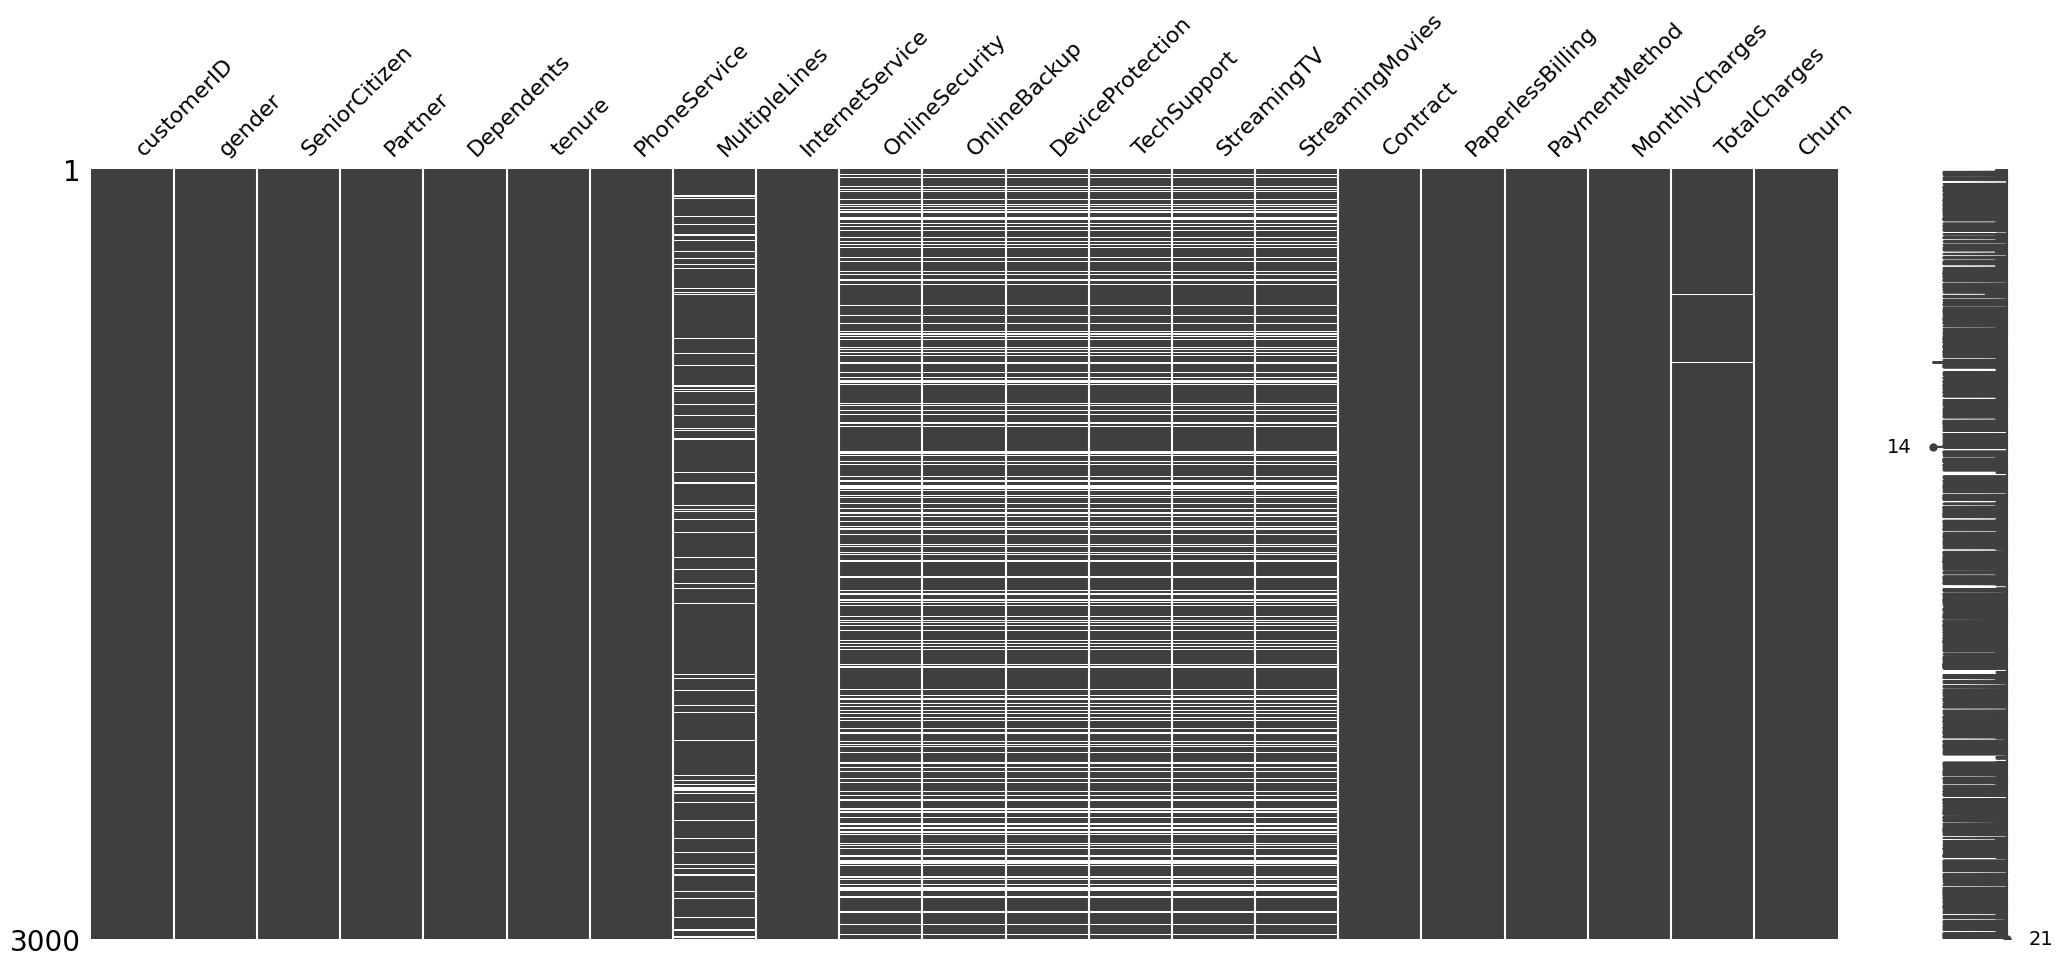

In [21]:
# Check for missing values in the first 3000 data points
check_missing_values(df_first_3000)


Missing values in the DataFrame:
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64


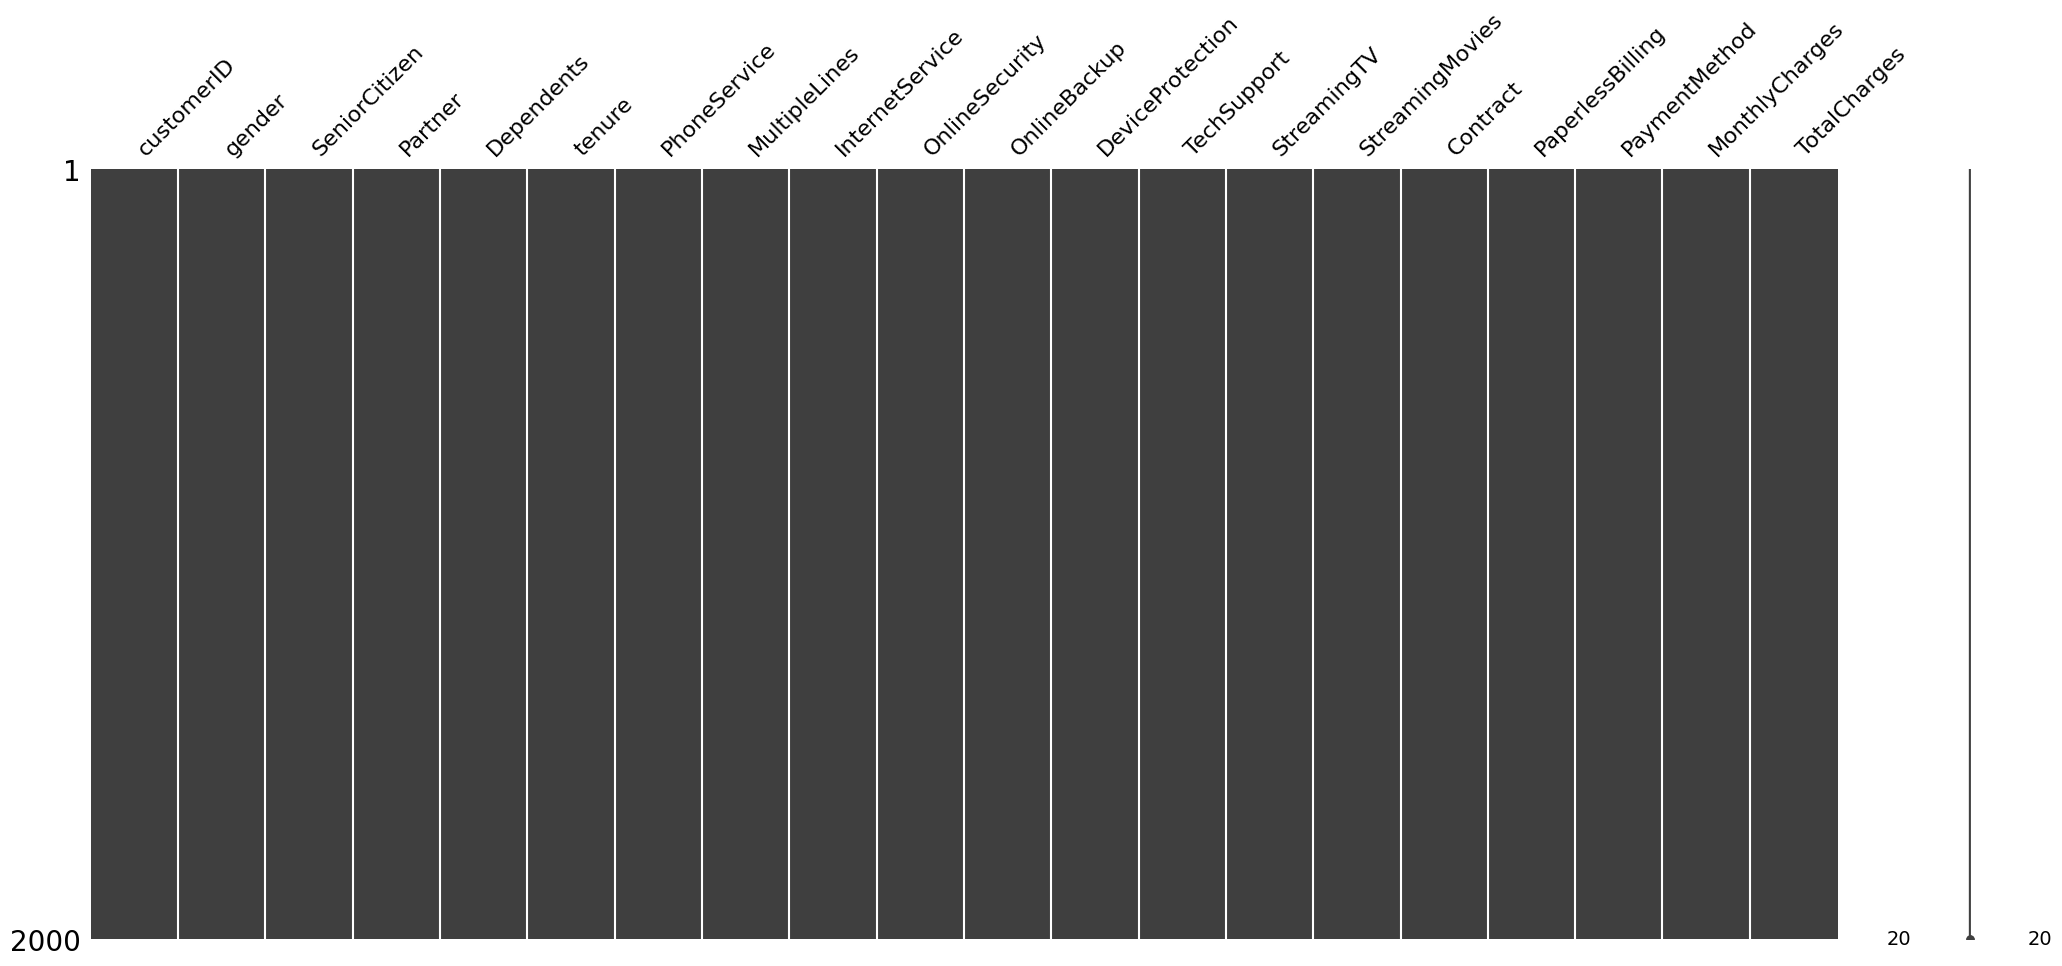

In [22]:
# Check for missing values in the second 2000 data points
check_missing_values(df_second_2000)


Missing values in the DataFrame:
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


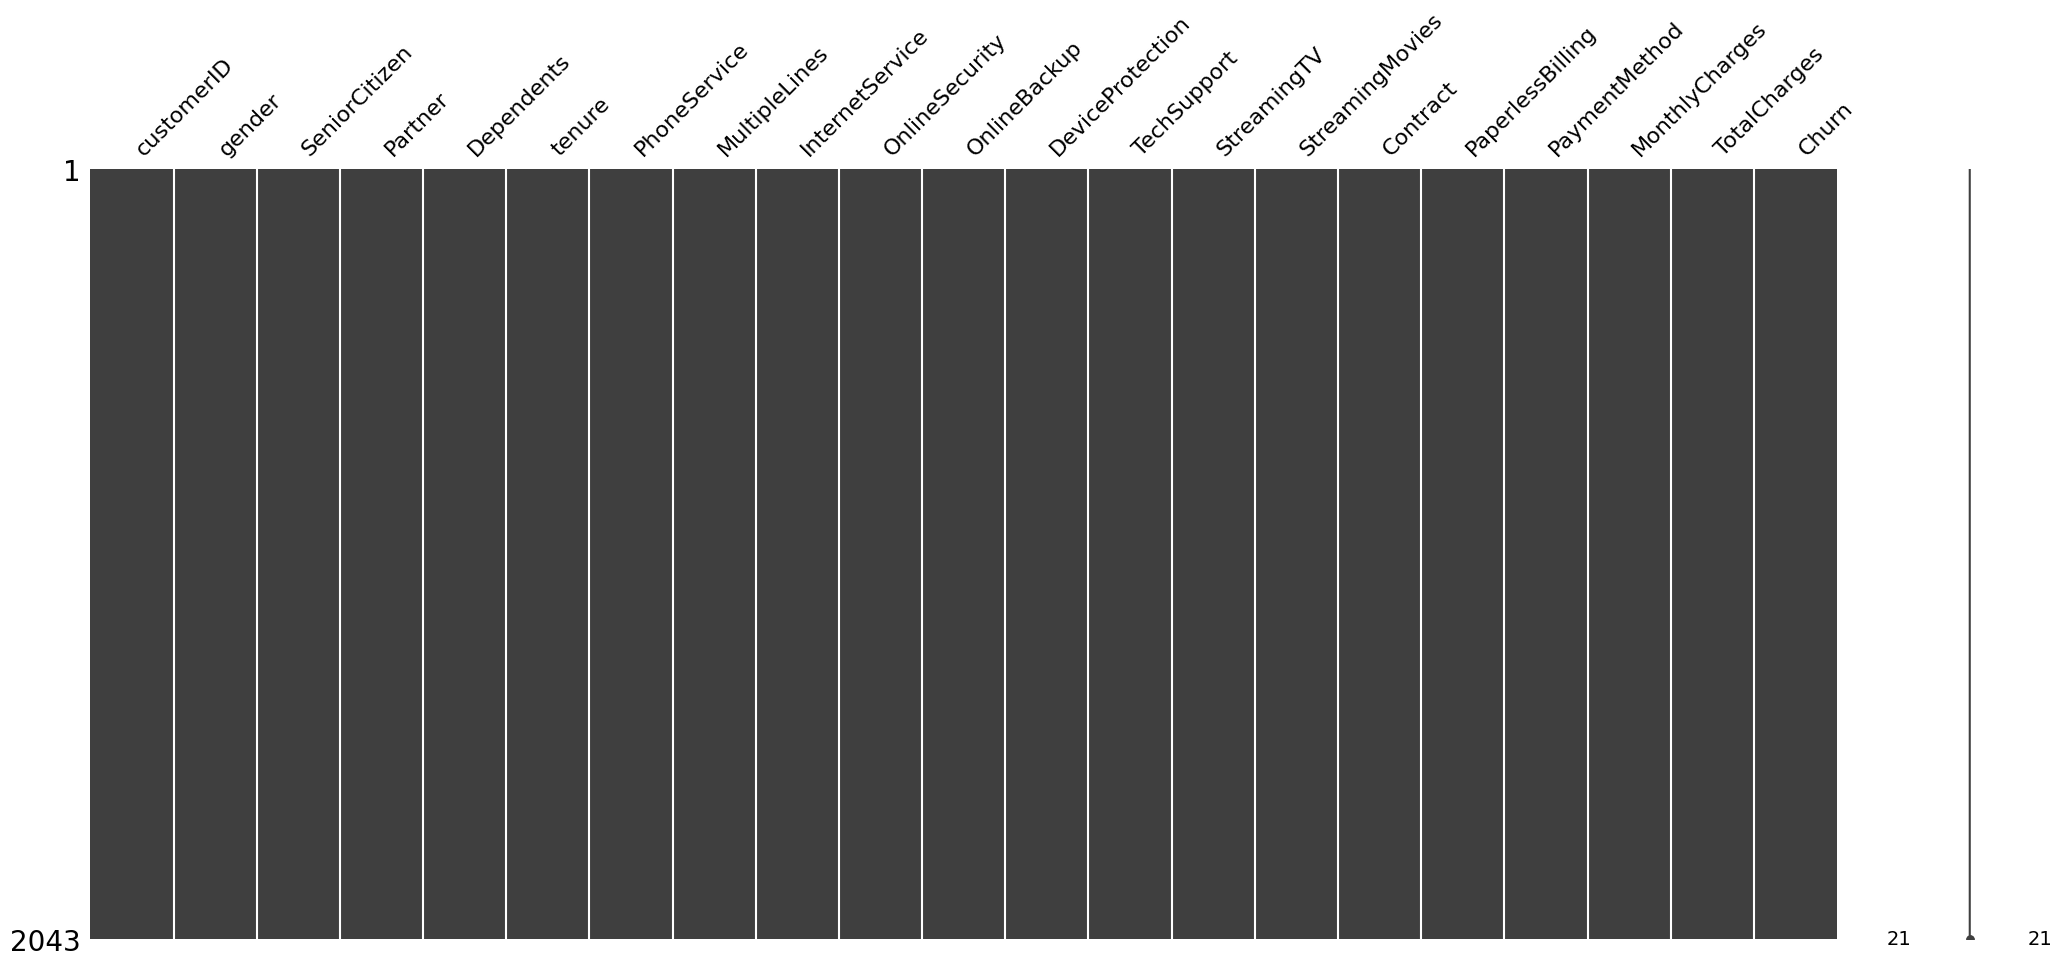

In [23]:
# Check for missing values in the last 2000 data points
check_missing_values(df_last_2000)


## DATA ASSESSMENT

Following data gathering from various sources, a comprehensive assessment was conducted to evaluate quality issues both visually and programmatically.

### DATA QUALITY ISSUES

During the preliminary dataset exploration, several data quality issues were identified, and they are summarized below:


1. Accuracy:
   - Most of the categorical columns in the first DataFrame use True to represent Yes and False to represent No, creating inconsistency among the three datasets.


2. Validity:
   - In the second and third datasets, the TotalCharges column is of object data type instead of float, which should contain numerical values.


3. Consistency:
   - Inconsistent values in the categorical columns across the three data sets.

   
4. Completeness:
   - Missing data points in the Churn column (Target) and other columns in the first dataset.


# HYPOTHESIS

**Null Hypothesis (H0)**

The monthly subscription cost (MonthlyCharges) has no significant effect on customer churn (Churn) from the Vodafone network service.

**Alternate Hypothesis (H1)**

The monthly subscription cost (MonthlyCharges) has a significant effect on customer churn (Churn) from the Vodafone network service.


# ANALYTICAL QUESTIONS

**UNIVARIATE:**

1. **Distribution of Churn:** What is the proportion of customers who have churned versus those who have not churned?

2. **Distribution of Tenure:** How is the duration of customer subscriptions (tenure) distributed among all customers?

3. **Distribution of Senior Citizen Status:** What is the distribution of senior citizen status among all customers?

**BIVARIATE:**

4. **Distribution of Monthly Charges across Churn:** How does the monthly charges vary between customers who have churned and those who have not?

5. **Relationship between Churn and Customer Tenure:** Is there a correlation between customer tenure and the likelihood of churning?

6. **Distribution of Churn across Contract Types:** How does the proportion of churn vary across different contract types (month-to-month, one year, two-year)?

7. **Impact of Online Security Service on Churn:** Does the presence or absence of online security service influence customer churn rates?

8. **Impact of Online Backup Service on Churn:** How does the presence or absence of online backup service affect customer churn rates?

**MULTIVARIATE:**

9. **Impact of Internet Service Type on Monthly Charges and Churn:** How does the type of internet service (DSL, Fiber Optic, None) influence monthly charges and customer churn? Are Fiber Optic customers paying significantly higher charges compared to DSL customers, and does this affect their likelihood of churning?


# DATA CLEANING

In [24]:
# Define a dictionary for mapping boolean and None values to more meaningful categories
new_cat_values_mapping = {
    'MultipleLines': {True: 'Yes', False: 'No', None: 'No phone service'},
    'OnlineSecurity': {True: 'Yes', False: 'No', None: 'No internet service'},
    'OnlineBackup': {True: 'Yes', False: 'No', None: 'No internet service'},
    'DeviceProtection': {True: 'Yes', False: 'No', None: 'No internet service'},
    'TechSupport': {True: 'Yes', False: 'No', None: 'No internet service'},
    'StreamingTV': {True: 'Yes', False: 'No', None: 'No internet service'},
    'StreamingMovies': {True: 'Yes', False: 'No', None: 'No internet service'},
    'Churn': {True: 'Yes', False: 'No', None: 'No'},
    'Partner': {True: 'Yes', False: 'No'},
    'Dependents': {True: 'Yes', False: 'No'},
    'PaperlessBilling': {True: 'Yes', False: 'No'},
    'PhoneService': {True: 'Yes', False: 'No'},
    'SeniorCitizen': {True: 1, False: 0}  # Convert True to 1 and False to 0
}

# Use the replace method to map the categorical values in the DataFrame
df_first_3000.replace(new_cat_values_mapping, inplace=True)

In [25]:
# Confirm changes
check_unique_values(df_first_3000)

Checking unique values in categorical columns:
gender ----> ['Female' 'Male']
Partner ----> ['Yes' 'No']
Dependents ----> ['No' 'Yes']
PhoneService ----> ['No' 'Yes']
MultipleLines ----> ['No phone service' 'No' 'Yes']
InternetService ----> ['DSL' 'Fiber optic' 'No']
OnlineSecurity ----> ['No' 'Yes' 'No internet service']
OnlineBackup ----> ['Yes' 'No' 'No internet service']
DeviceProtection ----> ['No' 'Yes' 'No internet service']
TechSupport ----> ['No' 'Yes' 'No internet service']
StreamingTV ----> ['No' 'Yes' 'No internet service']
StreamingMovies ----> ['No' 'Yes' 'No internet service']
Contract ----> ['Month-to-month' 'One year' 'Two year']
PaperlessBilling ----> ['Yes' 'No']
PaymentMethod ----> ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn ----> ['No' 'Yes']


In [26]:
# Convert 'TotalCharges' to float and handle non-convertible values with NaN
df_second_2000['TotalCharges'] = pd.to_numeric(df_second_2000['TotalCharges'], errors='coerce')

df_last_2000['TotalCharges'] = pd.to_numeric(df_last_2000['TotalCharges'], errors='coerce')

In [27]:
# Verify the data type after conversion
df_second_2000['TotalCharges'].dtype, df_last_2000['TotalCharges'].dtype

(dtype('float64'), dtype('float64'))

In [28]:
# Concatenate the rows from df_first_3000 with all rows from df_last_2000 to create the training dataset.
train = pd.concat([df_first_3000, df_last_2000])

# Create a copy of df_second_2000 to create the test dataset.
test = df_second_2000.copy()

In [29]:
# Get more information about the train dataset
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5043 entries, 0 to 2042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5043 non-null   object 
 1   gender            5043 non-null   object 
 2   SeniorCitizen     5043 non-null   int64  
 3   Partner           5043 non-null   object 
 4   Dependents        5043 non-null   object 
 5   tenure            5043 non-null   int64  
 6   PhoneService      5043 non-null   object 
 7   MultipleLines     5043 non-null   object 
 8   InternetService   5043 non-null   object 
 9   OnlineSecurity    5043 non-null   object 
 10  OnlineBackup      5043 non-null   object 
 11  DeviceProtection  5043 non-null   object 
 12  TechSupport       5043 non-null   object 
 13  StreamingTV       5043 non-null   object 
 14  StreamingMovies   5043 non-null   object 
 15  Contract          5043 non-null   object 
 16  PaperlessBilling  5043 non-null   object 
 17  

In [30]:
# Get more information about the test dataset
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        2000 non-null   object 
 1   gender            2000 non-null   object 
 2   SeniorCitizen     2000 non-null   int64  
 3   Partner           2000 non-null   object 
 4   Dependents        2000 non-null   object 
 5   tenure            2000 non-null   int64  
 6   PhoneService      2000 non-null   object 
 7   MultipleLines     2000 non-null   object 
 8   InternetService   2000 non-null   object 
 9   OnlineSecurity    2000 non-null   object 
 10  OnlineBackup      2000 non-null   object 
 11  DeviceProtection  2000 non-null   object 
 12  TechSupport       2000 non-null   object 
 13  StreamingTV       2000 non-null   object 
 14  StreamingMovies   2000 non-null   object 
 15  Contract          2000 non-null   object 
 16  PaperlessBilling  2000 non-null   object 


Missing values in the DataFrame:
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        8
Churn               0
dtype: int64


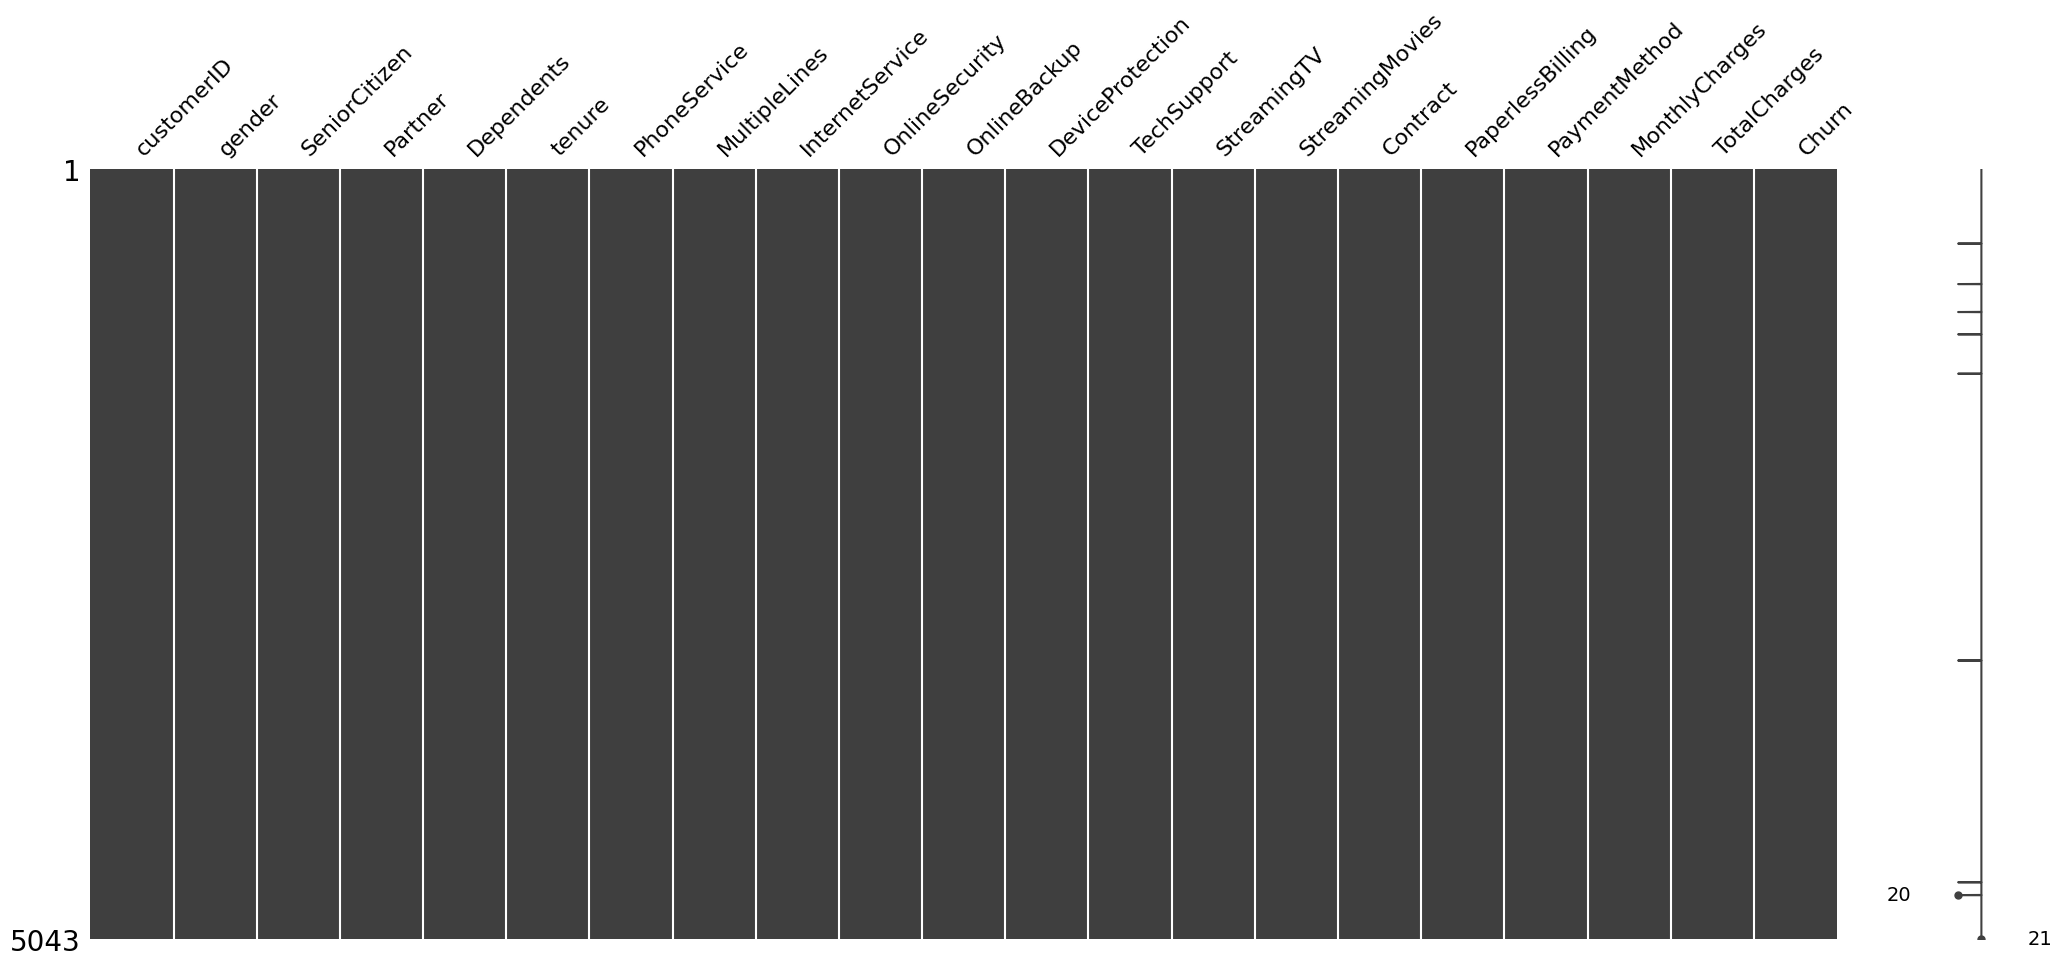

In [31]:
# Visualize the missing values in the train dataset
check_missing_values(train)

Missing values in the DataFrame:
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        3
dtype: int64


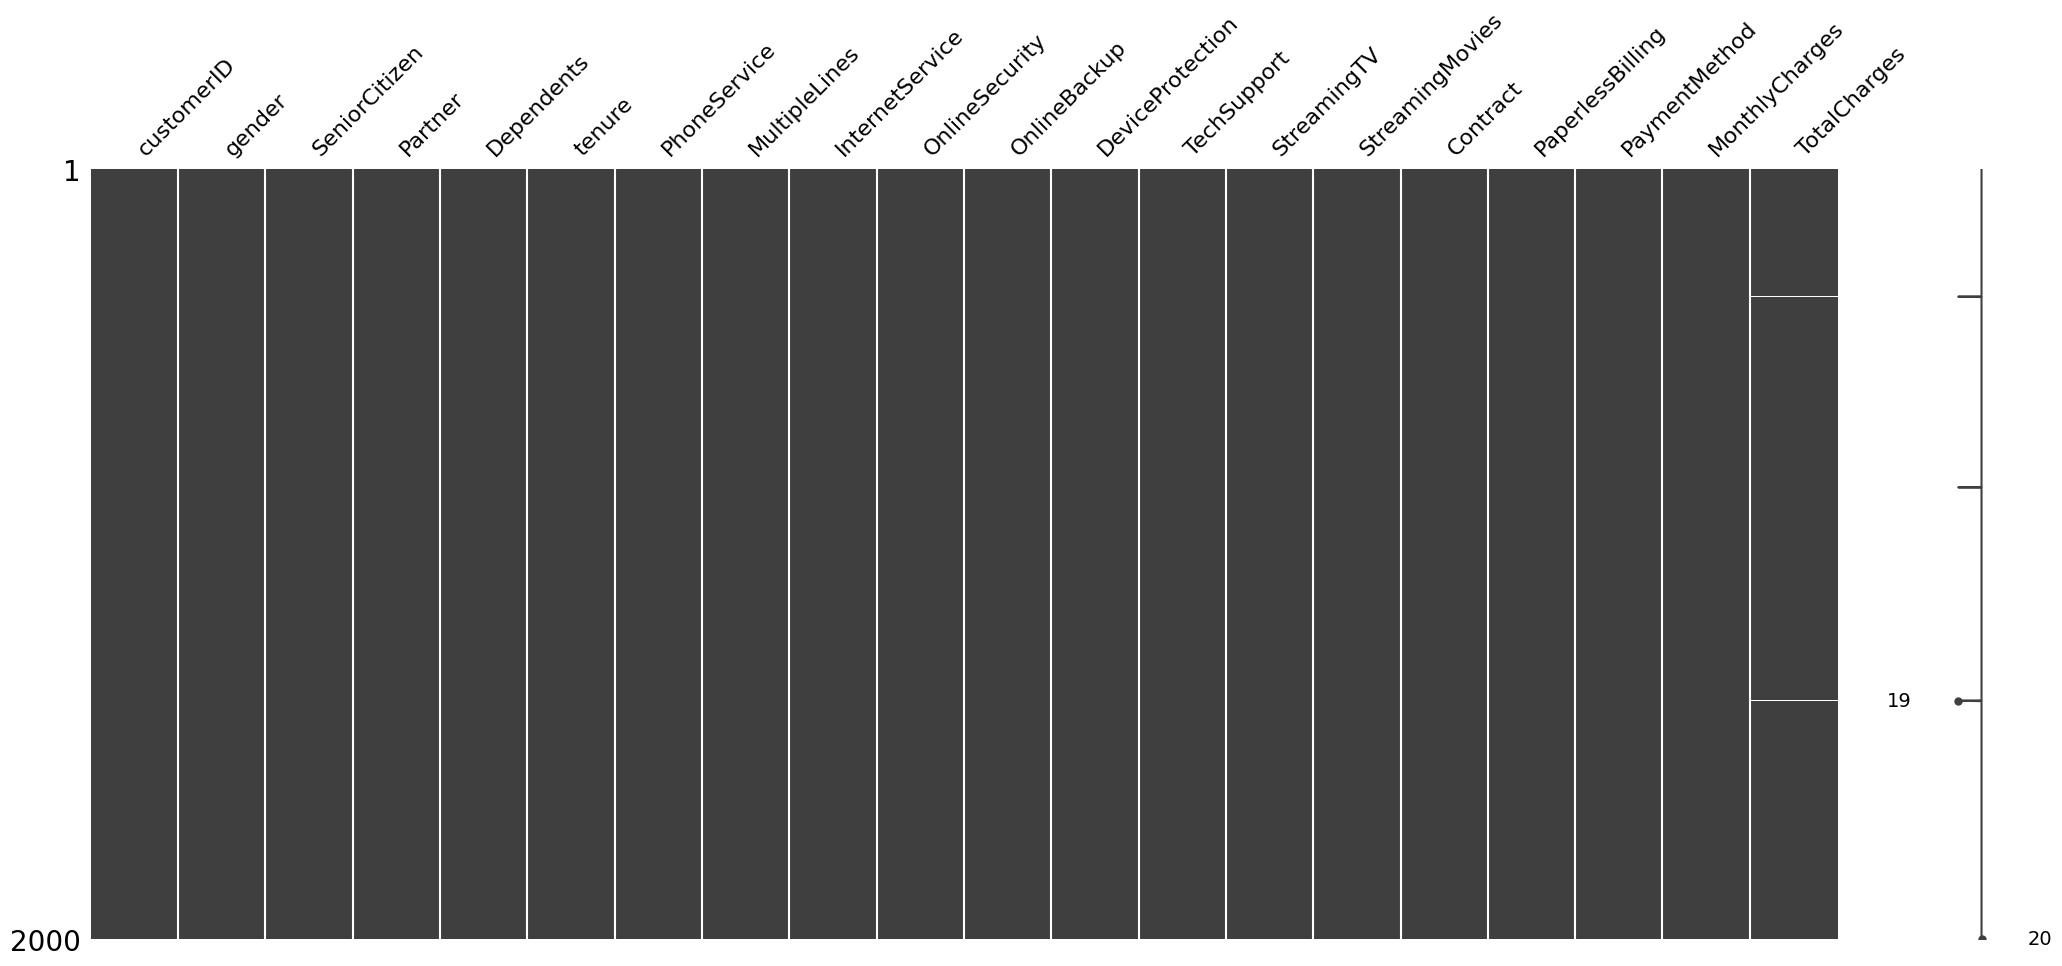

In [32]:
# Visualize the missing values in the test dataset
check_missing_values(test)

From the output above the train DataFrame contains `5043 entries` with `21 columns`, while the test DataFrame contains `2000 entries` with `20 columns`. The columns represent various customer attributes.

The data appears to have some missing values in the `TotalCharges` column, with `5035 non-null values` (8 data points) in the train DataFrame and `1997 non-null values` (3 data points) in the test DataFrame.

The missing values will be handled properly during the data preprocessing stage

In [33]:
# Generate descriptive statistics of the train dataset
train.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,5043.000000,5043.000000,5043.000000,5035.000000
mean,0.162403,32.576641,65.090214,2302.062861
std,0.368857,24.529807,30.068133,2269.483576
min,0.000000,0.000000,18.400000,18.799999
25%,0.000000,9.000000,35.775000,417.675003
50%,0.000000,29.000000,70.550003,1401.150024
75%,0.000000,56.000000,90.050003,3862.000000
max,1.000000,72.000000,118.650002,8670.100000


Based on the summary statistics above, the following are observed:


1. **SeniorCitizen:** This variable is binary, indicating that around 16.24% of the customers are senior citizens (1) while the majority are not (0).

2. **Tenure:** The average tenure of customers in the Vodafone network service is approximately 32.58 months. The data is spread out, with a standard deviation of 24.53, indicating some variation in the duration of customer subscriptions. The minimum tenure is 0 months, suggesting there are some new customers, while the maximum tenure is 72 months, representing the longest duration a customer has stayed with the service.

3. **MonthlyCharges:** The average monthly subscription cost for customers is approximately $65.09. The standard deviation of 30.07 shows that there is variability in the monthly charges across the dataset. The minimum monthly charge is $18.40, while the maximum is $118.65.

4. **TotalCharges:** The average total amount charged to customers is approximately $2302.06. The standard deviation of 2269.48 indicates significant variation in the total charges among customers. However, there are 8 missing values in this variable, as indicated by the difference in the count compared to other variables.

# HYPOTHESIS TESTING

In our hypothesis, we are interested in comparing the means of Monthly Charges between two independent groups: customers who have churned (Churn = "Yes") and customers who have not churned (Churn = "No").

The independent samples t-test is suitable for our analysis because we are comparing the mean Monthly Charges of two distinct groups (churned and non-churned customers) where the Monthly Charges of each customer are unrelated and independent of whether or not other customers have churned. 

The t-test allows us to test if there is a significant difference in the average Monthly Charges between these two groups, providing insights into the impact of Monthly Charges on customer churn.

### INDEPENDENT SAMPLES T-TEST RESULT

In [34]:
# Separate the independent Monthly Charges between the two groups
churn_yes = train[train['Churn'] == "Yes"]['MonthlyCharges']
churn_no = train[train['Churn'] == "No"]['MonthlyCharges']

# Perform the independent samples t-test (assuming equal variance)
t_statistic, p_value = stats.ttest_ind(churn_yes, churn_no)

# Define the significance level (alpha)
alpha = 0.05

# Print the results
print("T-Statistic:", t_statistic)
print("P-Value:", p_value)

# Check if the p-value is less than alpha to determine the significance
if p_value < alpha:
    print("Reject the null hypothesis: MonthlyCharges have a significant effect on churn.")
else:
    print("Fail to reject the null hypothesis: MonthlyCharges do not have a significant effect on churn.")

T-Statistic: 14.650610568422312
P-Value: 1.2575465113545793e-47
Reject the null hypothesis: MonthlyCharges have a significant effect on churn.


The statistical analysis yielded a calculated statistic of `14.65`, accompanied by a remarkably low p-value of approximately `1.26e-47`. 

With this statistical outcome, we confidently reject the null hypothesis and conclude that Monthly Charges exert a substantial influence on customer churn. 

The p-value indicates that the observed relationship between Monthly Charges and churn is highly unlikely to occur by chance, reinforcing the robustness of our findings. 

In practical terms, this implies a concrete and significant association between the amount a customer is billed monthly and the probability of them churning from the service.

# UNIVARIATE ANALYSIS

In [35]:
# Define custom color palette
custom_color_palette = ["#835AF1","#37AA9C", "#B8F7D4", "#94F3E4"]

# Set the custom color palette for Plotly Express
px.defaults.color_discrete_sequence = custom_color_palette

# QUESTION ONE


##### DISTRIBUTION OF CHURN: WHAT IS THE PROPORTION OF CUSTOMERS WHO HAVE CHURNED VERSUS THOSE WHO HAVE NOT CHURNED?

In [36]:
# Calculate the distribution of 'Churn' in the train dataset
churn_distribution = train['Churn'].value_counts().reset_index(name='Count')

# Calculate the percentage of each category
churn_distribution['Percentage'] = round((churn_distribution['Count'] / churn_distribution['Count'].sum()) * 100, 2)

# Print the distribution
print(churn_distribution)

# Plot the distribution with percentage
fig = px.bar(churn_distribution, 
             x='Churn', 
             y='Count', 
             color='Churn', 
             text='Percentage',  # Add percentage to hover text
             title='Churn Distribution with Percentage', 
             labels={'Count': 'Count', 'Churn': 'Churn', 'Percentage': 'Percentage (%)'}
             )


# Show plot
fig.show()


  Churn  Count  Percentage
0    No   3707       73.51
1   Yes   1336       26.49


The distribution of churn in the dataset shows that out of 5043 customers, 3707 (approximately 73.51%) have not churned (Churn = "No"), while 1336 customers (approximately 26.49%) have churned (Churn = "Yes"). 

This indicates that the majority of customers in the dataset have not churned, with a smaller proportion of customers having churned from the service.

The distribution of churn in the dataset reveals a problem of feature imbalance, where the majority of customers have not churned (Churn = "No") compared to the smaller proportion of customers who have churned (Churn = "Yes"). To address this issue appropriately, it will be handled during the data preprocessing stage by employing resampling technique. This ensures that the class imbalance is appropriately dealt with to avoid bias and improve the performance of the churn prediction model.

# QUESTION TWO

##### DISTRIBUTION OF TENURE: HOW IS THE DURATION OF CUSTOMER SUBSCRIPTIONS (TENURE) DISTRIBUTED AMONG ALL CUSTOMERS?

In [37]:
# Display the summary statistics of the 'tenure' column in the 'train' DataFrame
tenure_summary = train['tenure'].describe()

# Create a histogram using Plotly Express to visualize the distribution of customer tenure
fig = px.histogram(train, x='tenure', title='Distribution of Customer Tenure')

# Display the histogram
fig.show()

The customer tenure in the dataset ranges from 0 to 72 months, with an average tenure of approximately 32.58 months and a spread of approximately 24.53 months around the mean. The majority of customers have tenures concentrated around 0 to 20 and 60 to 72 months, with 25% having tenures of 9 months or less, and 75% having tenures of 56 months or less.

The histogram chart displays the distribution of customer tenure in the Vodafone network service, ranging from 0 to 72 months. There are two main concentration areas: one around 0 to 20 months, indicating the presence of new customers, and another around 60 to 72 months, representing customers with longer loyalty. This suggests that a substantial number of customers tend to have relatively short tenure with the service.

To better understand how tenure influences churn behavior, we will analyze it together with the Churn status to gain valuable insights into customer retention patterns and factors affecting churn decisions.

# QUESTION THREE

##### DISTRIBUTION OF SENIOR CITIZEN STATUS: WHAT IS THE DISTRIBUTION OF SENIOR CITIZEN STATUS AMONG ALL CUSTOMERS?

In [38]:
# Calculate the distribution of 'SeniorCitizen' in the train dataset
citizen_distribution = train['SeniorCitizen'].astype('category').value_counts().reset_index(name = 'Count')

# Print the distribution
print(citizen_distribution)

# Plot the distribution
fig = px.bar(citizen_distribution, x='SeniorCitizen', y='Count', color='SeniorCitizen', title='Senior Citizen Distribution')

# Update layout
fig.update_layout(xaxis_tickmode='linear', xaxis_title='Senior Citizen', yaxis_title='Number of Customers')

# Show plot
fig.show()

  SeniorCitizen  Count
0             0   4224
1             1    819


The bar chart provides a visual representation of the distribution of senior citizen status among all customers. The  distribution of senior citizen status among all customers is skewed towards non-senior citizens and shows that 819 customers (16.3%) are senior citizens, while 4224 customers (83.7%) are not senior citizens.

# BIVARIATE

# QUESTION FOUR

##### DISTRIBUTION OF MONTHLY CHARGES ACROSS CHURN: HOW DOES THE MONTHLY CHARGES VARY BETWEEN CUSTOMERS WHO HAVE CHURNED AND THOSE WHO HAVE NOT?

In [39]:
# Create a box plot to visualize the distribution of Monthly Charges across churned and non-churned customers
fig = px.box(train, x='Churn', y='MonthlyCharges', color='Churn', title='Distribution of Monthly Charges across Churn')

# Set the y-axis label for better clarity
fig.update_layout(yaxis_title='Monthly Charges')

# Display the plot
fig.show()

Overall, the box plot illustrates that the price of the monthly subscription (MonthlyCharges) plays a significant role in influencing customer churn. Customers with higher monthly charges are more likely to churn compared to those with lower charges. This discovery holds important implications for devising effective customer retention strategies and making informed pricing decisions within the Vodafone network service.

# QUESTION FIVE

##### RELATIONSHIP BETWEEN CHURN AND CUSTOMER TENURE: IS THERE A CORRELATION BETWEEN CUSTOMER TENURE AND THE LIKELIHOOD OF CHURNING?

In [40]:
# Plot a histogram graph
fig = px.histogram(train, x='tenure', color='Churn', title='Relationship between Churn and Customer Tenure')

# Update layout
fig.update_layout(yaxis_title='Count', xaxis_title='Tenure')

# Show plot
fig.show()

This graph above shows that the number of customers who churn with the Vodafone network service is highest in the first few months of being with the company. This is likely because customers are more likely to be dissatisfied with their service in the early months, when they are still learning about the company and its offerings.

The graph exhibit a right-skewed distribution, which means that the customers tenure is distributed unevenly, with the most number of customers churning in the first few months and fewer customers churning at the extremes of the distribution.

To be able to accurately assess the churn rate, a further analysis on the contract type will be accessed.

# QUESTION SIX

##### DISTRIBUTION OF CHURN ACROSS CONTRACT TYPES: HOW DOES THE PROPORTION OF CHURN VARY ACROSS DIFFERENT CONTRACT TYPES (MONTH-TO-MONTH, ONE YEAR, TWO-YEAR)?

In [41]:
# Group the data by 'Contact' and 'Churn' columns and count the occurrences of each category combination
churn_by_contract = train.groupby(['Contract', 'Churn'])['Contract'].value_counts().reset_index(name='Count')

# Create a grouped bar plot to visualize the count of churned and non-churned customers
fig = px.bar(churn_by_contract, x='Contract', y='Count', color='Churn', barmode='group', title='Customer Churn by Contract Terms')

# Update layout
fig.update_layout(xaxis_title ='Contract', yaxis_title='Number of Customers')

# Show plot
fig.show()

The graph shows that the churn rate is highest for customers with month-to-month contracts. Of the 2744 customers with month-to-month contracts, 1184 have churned, for a churn rate of 43.1%. The churn rate is lower for customers with one-year contracts (11.6%) and two-year contracts (2.4%).

This suggests that customers with month-to-month contracts are more likely to churn than customers with one-year or two-year contracts. This could be because customers with month-to-month contracts are more likely to be dissatisfied with the service or because they are more likely to find a better deal from a competitor.

Table Representation

|Contract Type|Churn rate (in %)|
|---|---|
|Moth-to-month|43.1|
|One year| 11.6|
|Two year| 2.4|

The graph also shows that the majority of customers who churn have month-to-month contracts. Of the 1336 customers who have churned, 1184 have month-to-month contracts, 122 have one-year contracts, and 30 have two-year contracts.

# QUESTION SEVEN

##### IMPACT OF ONLINE SECURITY SERVICE ON CHURN: DOES THE PRESENCE OR ABSENCE OF ONLINE SECURITY SERVICE INFLUENCE CUSTOMER CHURN RATES?

In [42]:
# Group the data by 'OnlineSecurity' and 'Churn' columns and count the occurrences of each category combination
churn_by_online_security = train.groupby(['OnlineSecurity', 'Churn'])['OnlineSecurity'].value_counts().reset_index(name='Count')

# Create a grouped bar plot to visualize the count of churned and non-churned customers
fig = px.bar(churn_by_online_security, x='OnlineSecurity', y='Count', color='Churn', barmode='group', title='Customer Churn by Online Security Service')

# Update layout
fig.update_layout(xaxis_title ='Online Security', yaxis_title='Number of Customers')

# Show plot
fig.show()

The grouped bar graph displays the relationship between the presence of Online Security service (Yes or No) and the customer churn status (Yes or No) within the Vodafone network service. Let's focus on examining the churn rates between customers with Online Security service enabled (OnlineSecurity = Yes) and those without it (OnlineSecurity = No).

- For customers with Online Security service (OnlineSecurity = Yes), the graph indicates that 1242 customers did not churn (Churn = No), while 214 customers churned (Churn = Yes). This results in a churn rate of approximately 14.70%.

- On the other hand, for customers without Online Security service (OnlineSecurity = No), the graph shows 1461 customers who did not churn (Churn = No), and 1046 customers who churned (Churn = Yes). This yields a churn rate of around 41.72%.

Table Representation

| Online Security | Churn rate (in %) |
|---|---|
| Yes | 14.70 |
| No | 41.72 |


The table illustrates a significant difference in churn rates between customers with Online Security service and those without it. Customers with Online Security service demonstrate a lower churn rate (14.70%) compared to customers without the service (41.72%). This suggests that the presence of Online Security service may play a role in reducing churn and enhancing customer retention within the Vodafone network service. 

# QUESTION EIGHT

##### IMPACT OF ONLINE BACKUP SERVICE ON CHURN: HOW DOES THE PRESENCE OR ABSENCE OF ONLINE BACKUP SERVICE AFFECT CUSTOMER CHURN RATES?

In [43]:
# Group the data by 'OnlineBackup' and 'Churn' columns and count the occurrences of each category combination
churn_by_online_backup = train.groupby(['OnlineBackup', 'Churn'])['OnlineBackup'].value_counts().reset_index(name='Count')

# Create a grouped bar plot to visualize the count of churned and non-churned customers
fig = px.bar(churn_by_online_backup, x='OnlineBackup', y='Count', color='Churn', barmode='group',  title='Customer Churn by Online Backup Service')

# Update plot layout to set the x and y axes title
fig.update_layout(xaxis_title='Number of Customers', yaxis_title='Online Backup')


# Show plot
fig.show()

The grouped bar graph visually represents the relationship between the presence of the Online Backup service (Yes or No) and the customer churn status (Yes or No). Let's focus on analyzing the churn rate between customers with Online Backup service enabled (OnlineBackup = Yes) and those without the service (OnlineBackup = No).

- For customers with Online Backup service (OnlineBackup = Yes), the graph shows that 1363 customers did not churn (Churn = No) while 369 customers churned (Churn = Yes). This results in a churn rate of approximately 21.30% for customers with Online Backup service.

- On the other hand, for customers without Online Backup service (OnlineBackup = No), the graph displays 1340 customers who did not churn (Churn = No) and 891 customers who churned (Churn = Yes). This yields a churn rate of around 39.93% for customers without Online Backup service.

Table Representation
|Online Backup| Churn rate (in %)|
|---|---|
|Yes|21.30%|
|No|39.93|

The table highlight a substantial difference in churn rates between these two customer segments. Customers with Online Backup service show a lower propensity to churn, suggesting that the presence of this service might have a positive influence on customer retention within the Vodafone network. 

# MULTIVARIATE ANALYSIS

# QUESTION NINE

##### IMPACT OF INTERNET SERVICE TYPE ON MONTHLY CHARGES AND CHURN: HOW DOES THE TYPE OF INTERNET SERVICE (DSL, FIBER OPTIC, NONE) INFLUENCE MONTHLY CHARGES AND CUSTOMER CHURN? ARE FIBER OPTIC CUSTOMERS PAYING SIGNIFICANTLY HIGHER CHARGES COMPARED TO DSL CUSTOMERS, AND DOES THIS AFFECT THEIR LIKELIHOOD OF CHURNING?

In [44]:
# Group the data by 'InternetService' and 'Churn' columns and calculate the sum of their monthly charges of each category combination
mon_charge_by_internet_service = train.groupby(['InternetService', 'Churn'])['MonthlyCharges'].sum().reset_index(name='MonthlyCharge')

# Create a grouped bar plot to visualize the monthly charge and count of churned and non-churned customers
fig = px.bar(mon_charge_by_internet_service, x='InternetService', y='MonthlyCharge', color='Churn', barmode='group', title='Monthly Charges and Churn Rate by InternetService Type')

# Update plot layout to set the x and y axes title
fig.update_layout(xaxis_title='Internet Service Type', yaxis_title='Monthly Charge')

# Show plot
fig.show()

The group bar graph shows that there is a significant difference in monthly charges between DSL and fiber optic customers. Fiber optic customers are paying an average a very high amount per month than DSL customers. This difference is likely due to the fact that fiber optic is a faster and more reliable internet service than DSL.

But the graph also reveals an interesting pattern, there is a significant difference in churn rates between DSL and fiber optic customers. Fiber optic customers are more likely to churn than DSL customers. This is likely because fiber optic customers are paying more for their service, so they are more likely to be dissatisfied with their service if it is not meeting their expectations.

Overall, the findings suggest that the type of internet service (DSL, fiber optic, or none) has a significant impact on monthly charges and customer churn. Fiber optic customers are paying significantly more for their service, but they are also more likely to churn. This suggests that businesses need to carefully consider the needs of their customers when deciding which type of internet service to offer.

# DATA PREPROCESSING

### HANDLING OF MISSING VALUES

In [45]:
# Plot histogram of the Total Charges Column
fig = px.histogram(train, x='TotalCharges', title='Distribution of Total Charges')

# Summary Statistics
print(train['TotalCharges'].describe())

# Show plot
fig.show()

count    5035.000000
mean     2302.062861
std      2269.483576
min        18.799999
25%       417.675003
50%      1401.150024
75%      3862.000000
max      8670.100000
Name: TotalCharges, dtype: float64


During the exploratory data analysis (EDA) phase, a significant variable named "TotalCharges" with missing values came to our attention. To tackle this, we assessed two imputation strategies: mean imputation and median imputation. To make an informed choice, we delved into the descriptive statistics of the "TotalCharges" variable, revealing a distribution that was right-skewed, included extreme values `(Min: $18.79 - Max: $8670.10)`, and exhibited a considerable standard deviation of `$2269.48`.

Given these characteristics, we opted for median imputation as the optimal approach. Median imputation, known for its resilience to outliers and its ability to provide a stable estimate of the central value, emerged as the most suitable strategy. 

This choice ensured that the imputed values harmonized with the data's central tendency while minimizing the impact of extreme charges. This approach enhances the trustworthiness of subsequent analyses and modeling that rely on the "TotalCharges" variable. 

Moving forward, we will leverage the SimpleImputer within the preprocess_data function to effectively manage missing values through median imputation.

In [46]:
# Save the train set to train.csv for power Bi visualization
train.to_csv('clean_train.csv', index=False)

### FEATURE SELECTION

In [47]:
# Calculate the phik correlation matrix for the 'Churn' column
churn_corr = train.phik_matrix().loc['Churn']

interval columns not set, guessing: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']


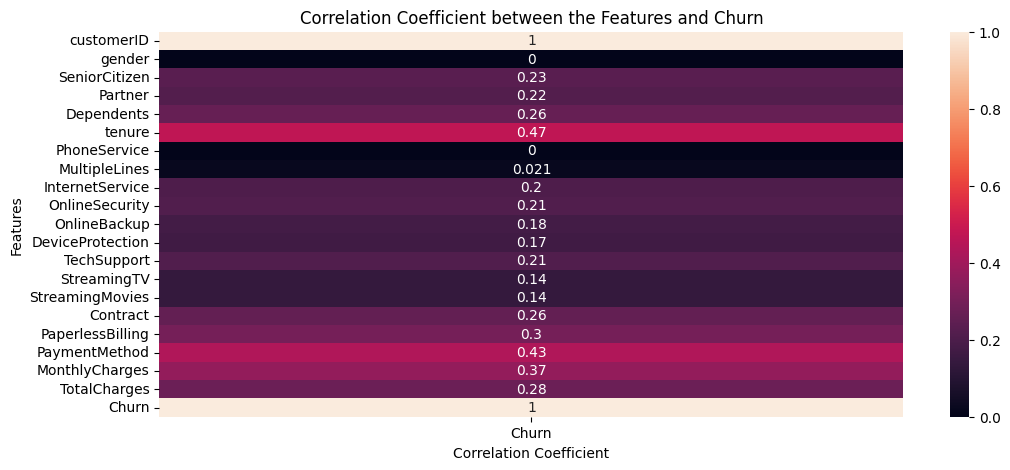

In [48]:
# Set the figure size for the heatmap
plt.figure(figsize=(12, 5))

# Create a heatmap with annotations
sns.heatmap(churn_corr.to_frame(), annot=True)

# Set the title for the heatmap
plt.title('Correlation Coefficient between the Features and Churn')

# Set the labels for the y-axis and x-axis
plt.ylabel('Features')
plt.xlabel('Correlation Coefficient')

# Show the heatmap
plt.show()

### DATA PREPARATION

In [49]:
# Convert 'SeniorCitizen' to object type to avoid numeric encoding (if not already done)
train['SeniorCitizen'] = train['SeniorCitizen'].astype('object')

# Split the data into features (X) and the target variable (y)
X = train.drop(['customerID', 'Churn'], axis=1).copy()
y = train['Churn']


In [50]:
def preprocess_data(df: pd.DataFrame):
    """
    Preprocess the data by imputing missing values, encoding categorical columns and scaling numerical columns.

    Parameters:
        df (DataFrame): data.

    Returns:
        preprocessed_data (array): Preprocessed data.
    """

    # Identify categorical and numerical columns
    cat_cols = df.select_dtypes('object').columns
    num_cols = df.select_dtypes('number').columns

    # Impute the missing values using Simple Imputer
    imputer = SimpleImputer(strategy='median', missing_values=np.NaN)

    # Apply it to impute the missing values in the totalCharges
    df['TotalCharges'] = imputer.fit_transform(df[['TotalCharges']])

    # Create a ColumnTransformer to handle encoding and scaling
    preprocessor = ColumnTransformer([
        ('scale', StandardScaler(), num_cols),
        ('encode', OneHotEncoder(), cat_cols),
    ])
    
    # Preprocess the training data
    preprocessed_data = preprocessor.fit_transform(df)

    # Get the various transformers
    encoder = preprocessor.named_transformers_['encode']
    scaler = preprocessor.named_transformers_['scale']

    # Access the feature names using the get_feature_names_out() method
    encoded_feature_names = encoder.get_feature_names_out(input_features=cat_cols)
    scaled_feature_names = scaler.get_feature_names_out(input_features=num_cols)

    # Form a list of all features
    all_feature_names = list(scaled_feature_names) + list(encoded_feature_names)

    
    return preprocessed_data, all_feature_names


In [51]:
# Encode the y  to have 0 or 1 instead of Yes or No
labelEncoder = LabelEncoder()

y = labelEncoder.fit_transform(y)

In [52]:
# Preprocess the training data and retrieve all the feature names
X, feature_names = preprocess_data(X)

### HANDLING CLASS IMBALANCE WITH SMOTE

In the context of our project, we encountered a class imbalance issue within the target variable, "Churn." This means that the number of instances belonging to each class was not balanced, potentially leading to skewed model performance.

To tackle this challenge, we turned to the Synthetic Minority Over-sampling Technique (SMOTE). This ingenious technique generates synthetic samples for the minority class, in our case, the churned customers, with the goal of achieving a more balanced class distribution. The strategy behind SMOTE is to alleviate the class imbalance problem by creating synthetic instances that lie between existing instances of the minority class.

In [53]:
# Class distribution of y before resampling 
pd.value_counts(pd.Series(y))

0    3707
1    1336
Name: count, dtype: int64

In [54]:
# Apply SMOTE to the entire dataset
smote = SMOTE(sampling_strategy='auto', k_neighbors=5, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [55]:
# Confirm changes after using SMOTE to handle class imbalance
pd.DataFrame(X_resampled).shape, pd.DataFrame(y_resampled).shape

((7414, 46), (7414, 1))

In [56]:
# Class distribution of y after resampling 
pd.value_counts(pd.Series(y_resampled))

0    3707
1    3707
Name: count, dtype: int64

Before applying SMOTE, our class distribution indicated a significant disparity:

- Non-Churn (Class 0): 3707 instances
- Churn (Class 1): 1336 instances

By applying SMOTE with parameters "sampling_strategy='auto', k_neighbors=5, random_state=42," we effectively increased the number of instances in the minority class. The result was a balanced class distribution:

- Non-Churn (Class 0): 3707 instances
- Churn (Class 1): 3707 instances

This rebalanced distribution sets the stage for more accurate and reliable model training and evaluation. By addressing the class imbalance using SMOTE, we ensure that our predictive models are not biased toward the majority class and can accurately capture patterns and insights from both classes.

### TRAIN-TEST SPLIT

In [57]:
# Split the data into training and validation sets with a test size of 20% and random state of 12
X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=12, stratify=y_resampled)

# Print the shapes of the training and validation sets to check the split
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(5931, 46) (1483, 46) (5931,) (1483,)


We executed the crucial step of splitting our data into training and validation sets using the `train_test_split` function.  In the `test_size`, we allocated 20% of the data to the validation set. 

The `stratify` parameter helps maintain the balanced class distribution in both the training and testing sets. Since we've previously balanced the classes using SMOTE, it's important to preserve this balance during the data split. 

This ensured that the model's training phase was conducted on one subset, while its performance assessment was carried out on an unseen subset. By integrating SMOTE and data splitting, we not only alleviated class imbalance concerns but also ensured a robust evaluation of our model's generalization capabilities.

# MODELLING

### MODEL SELECTION

We consider seven (7) models for churn prediction:

1. Logistic Regression
2. Gaussian Naive Bayes
3. Random Forest Classifier
4. KNeighbors Classifier
5. Decision Tree Classifier
6. Gradient Boosting Classifier
7. Support Vector Classifier (SVC)

We evaluate each model's performance using cross-validation to ensure reliable metrics. The key evaluation metric used is accuracy.

In [58]:
models = [
    ('Logistic Regression', LogisticRegression(random_state=42)),
    ('GaussianNB', GaussianNB()),
    ('Random Forest Classifier', RandomForestClassifier(random_state=42)),
    ('KNeighbors Classifier', KNeighborsClassifier()),
    ('Decision Tree Classifier', DecisionTreeClassifier(random_state=42)),
    ('Gradient Boosting Classifier', GradientBoostingClassifier(random_state=42)),
    ('SVC', SVC(random_state=42))
]

# Create an empty dictionary to store the results
results = {
    'Model': [],
    'Accuracy': []
}

# Loop through each model and calculate performance metrics using cross-validation
for model_name, model in models:
    
    # Define the scoring metrics to calculate
    scoring = ['accuracy']

    # Perform cross-validation and get the results
    cv_results = cross_validate(model, X_train, y_train, cv=5, scoring=scoring)

    # Store the average scores for each metric in the results dictionary
    results['Model'].append(model_name)
    results['Accuracy'].append(cv_results['test_accuracy'].mean())

In [59]:
# covert the results map to a DataFrame, Sort Values by Accuracy
results = pd.DataFrame(results).sort_values(by='Accuracy', ascending=False)

# Confirm changes
results

,Model,Accuracy
2,Random Forest Classifier,0.854832
5,Gradient Boosting Classifier,0.847414
6,SVC,0.810825
3,KNeighbors Classifier,0.789410
4,Decision Tree Classifier,0.787221
0,Logistic Regression,0.778623
1,GaussianNB,0.758557


### MODEL PERFORMANCE VISUALIZATION

To visually compare model performances, we create a bar plot using Plotly Express. The bar plot displays the accuracy metric for each model, providing an easy-to-understand representation of their relative performances.


In [60]:
# Plot the bar graph
fig = px.bar(results, x='Model', y='Accuracy',
             title='Model Performance Metrics',
             labels={'Model': 'Model Name', 'Accuracy': 'Mean Accuracy Score (5 Folds)'}
            )

# Show the plot
fig.show()

The `Random Forest Classifier` stands out as the best-performing model due to its highest accuracy among the evaluated models `(85.48%)`. As accuracy is a key performance metric for our project, selecting the Random Forest Classifier ensures that we prioritize correctly predicting customer churn in our future predictions on the test dataset.

This combination of high accuracy, and interpretability makes the Random Forest Classifier an ideal choice for addressing the project's goals of identifying churn customers.

By selecting the Random Forest Classifier, we aim to leverage its predictive capabilities to make accurate and informed decisions regarding customer retention strategies.

# MODEL EVALUATION

A comprehensive evaluation of the Random Forest Classifier will be conducted using the validation set to identify its optimal performance. 

The evaluation primarily focused on analyzing the models' performance through the lens of the confusion matrix. This matrix provides a detailed breakdown of the model's predictions, allowing us to make informed decisions about its effectiveness.

In [61]:
# Create a function to generate the classification report and also plot the confusion matrix

def get_model_performance(y_val, y_pred):
    """
    Generate a classification report and plot a confusion matrix using Plotly Express.

    Parameters:
    y_val (array-like): The true labels.
    y_pred (array-like): The predicted labels.
   
    Returns:
    None
        The function prints the classification report and displays the confusion matrix plot.
    """

    # Define a custom color scale
    custom_color_scale = [[0.0, "#835AF1"],
                        [0.5, "#37AA9C"],
                        [1.0, "#B8F7D4"]] 

    # Define class labels
    class_labels = ['Churn', 'Not Churn']

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(y_val, y_pred)
    
    
    # Create classification report
    report = classification_report(y_val, y_pred, target_names=class_labels)

    # Print report
    print(report)

    # Create a DataFrame for the confusion matrix
    conf_df = pd.DataFrame(conf_matrix, index=class_labels, columns=class_labels)

    # Create a heatmap with annotations
    fig = px.imshow(conf_df,
                    labels=dict(x='Predicted', y='Actual'),
                    x=class_labels,
                    y=class_labels,
                    color_continuous_scale=custom_color_scale)

    # Add annotations to display the values within the cells
    for i in range(len(class_labels)):
        for j in range(len(class_labels)):
            fig.add_annotation(x=class_labels[j], y=class_labels[i],
                            text=str(conf_matrix[i, j]),
                            showarrow=False, font=dict(size=16, color='white'))

    # Customize the layout
    fig.update_layout(title='Confusion Matrix',
                    xaxis_title='Predicted',
                    yaxis_title='Actual')

    # Show the plot
    fig.show()

In [62]:
# Create a RandomForestClassifier model
rf_model = RandomForestClassifier(random_state=42)

# Fit the RandomForestClassifier model on the training data
rf_model.fit(X_train, y_train)

# Predict the labels on the validation data using the trained model
rf_y_pred = rf_model.predict(X_val)

# Evaluate the model performance using the get_model_performance function and display results
get_model_performance(y_val, rf_y_pred)

              precision    recall  f1-score   support

       Churn       0.86      0.88      0.87       741
   Not Churn       0.87      0.85      0.86       742

    accuracy                           0.87      1483
   macro avg       0.87      0.87      0.87      1483
weighted avg       0.87      0.87      0.87      1483



From the confusion matrix above, each cell represents different outcomes of the classifier's prediction. 

- **True Positives (TP)**: The model predicted `649` as true positives. These are the instances where the model correctly identified customers as `"Churn"` cases.

- **False Positives (FP)**: The model predicted `108` customers as false positives. These are cases where the model predicted `"Churn"` but the customers actually did not churn. These potentially represent customers who were incorrectly flagged as churning, leading to unnecessary interventions.

- **True Negatives (TN)**: The model predicted `634` customers as true negatives. These are cases where the model correctly identified customers as `"Not Churn"` cases. These customers were correctly classified as not churning.

- **False Negatives (FN)**: The model predicted `92` customers as false negatives. These are instances where the model predicted `"Not Churn"`,  but the customers actually did churn. These are the most critical cases as they involve actual churn cases being missed by the model, potentially leading to lost opportunities for retention.

**Classification Metrics**:

- **Accuracy**: The overall accuracy of the model, which considers both correct and incorrect predictions, is the sum of TP and TN divided by the total number of predictions. It indicates the overall proportion of correct predictions and it's calculated as `(649 + 634) / 1483 = 86.5%`.

- **Precision**: Precision `(TP / (TP + FP))` focuses on the accuracy of positive predictions. It measures how many of the predicted `"Churn"` cases were actually churn and it's calculated as `649 / (649 + 108) = 85.7%`. A high precision indicates that when the model predicts `"Churn"`, it's often correct.

- **Recall (Sensitivity)**: Recall `(TP / (TP + FN))` evaluates the model's ability to identify all positive cases correctly. It shows what proportion of actual `"Churn"` cases were identified and it's calculated as `649 / (649 + 92) = 87.6%`. A high recall means the model can effectively find most of the `"Churn"` cases.

- **F1-Score**: The F1-score `(2 * (Precision * Recall) / (Precision + Recall)) = 93%` is the harmonic mean of precision and recall. It provides a balanced assessment of the model's performance, considering both false positives and false negatives. A higher F1-score indicates a better balance between precision and recall.


The decision to focus on its hyperparameter tuning aims to further optimize its performance and deliver accurate predictions on the test dataset, ultimately supporting the business objective of enhancing customer churn management.


# MODEL  IMPROVEMENT

Here, we perform hyperparameter tuning using RandomizedSearchCV on a Random Forest Classifier model. It searches over a defined parameter grid and uses the Accuracy-score as the scoring metric. 

The best hyperparameters and the best Random Forest Classifier model are printed at the end.

In [63]:
# Define the parameter distributions for hyperparameter tuning
param_grid = {
  'n_estimators': [ 300],
  'max_depth': [None, 10, 15, 20, 25],
  'min_samples_split': [2],
  'min_samples_leaf': [1, 2],
  'class_weight': ['balanced', None],
  'max_features': ['auto', 'sqrt', 'log2'],
  'criterion': ['gini', 'entropy']
}


# Create a RandomForestClassifier model with a specific random seed
rf_model = RandomForestClassifier(random_state=42)

# Initialize RandomizedSearchCV with the RandomForestClassifier model and parameter distributions
random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_grid, 
                                   scoring='accuracy', n_iter=10,  # Specify number of iterations
                                   cv=5, n_jobs=-1, random_state=42)

# Fit the RandomizedSearchCV on the training data
random_search.fit(X_train, y_train)

# Get the best hyperparameters from the random search
best_params = random_search.best_params_
print('Best Hyperparameters: ', best_params)

# Get the best Random Forest model from the random search
best_rf_model = random_search.best_estimator_
print('Best Random Forest Classifier: ', best_rf_model)

# Evaluate the best model on the validation set
best_accuracy = best_rf_model.score(X_val, y_val)
print('The accuracy of the Model is: ', best_accuracy)


Best Hyperparameters:  {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None, 'criterion': 'gini', 'class_weight': 'balanced'}
Best Random Forest Classifier:  RandomForestClassifier(class_weight='balanced', max_features='log2',
                       n_estimators=300, random_state=42)
The accuracy of the Model is:  0.8745785569790965


In [64]:
# Fit the best RandomForestClassifier model on the training data
best_rf_model.fit(X_train, y_train)

# Predict the labels on the validation data using the trained model
best_rf_model_y_pred = best_rf_model.predict(X_val)

# Evaluate the model performance using the get_model_performance function and display results
get_model_performance(y_val, best_rf_model_y_pred)

              precision    recall  f1-score   support

       Churn       0.87      0.88      0.88       741
   Not Churn       0.88      0.87      0.87       742

    accuracy                           0.87      1483
   macro avg       0.87      0.87      0.87      1483
weighted avg       0.87      0.87      0.87      1483



The optimal configuration for the Random Forest Classifier, determined through hyperparameter tuning, 'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None, 'criterion': 'gini', 'class_weight': 'balanced'. This fine-tuned model exhibits an impressive accuracy of about `87.45%` from `86.5%`, demonstrating its robustness.

This significant improvement underscores the effectiveness of hyperparameter tuning in maximizing model performance for predicting customer churn.

Upon conducting hyperparameter tuning, the slight adjustment in the confusion matrix demonstrates the refined predictive capability of the model, with improved accuracy in correctly classifying instances of customer churn and non-churn.

# FUTURE PREDICTIONS

### PREPROCESS TEST DATA

In [65]:
# Store the CustomerID column before dropping it from the test data
customerID = test['customerID']

# Drop the CustomerID column from the test data
test.drop('customerID', axis=1, inplace=True)

# Convert 'SeniorCitizen' to object type to avoid numeric encoding (if not already done)
test['SeniorCitizen'] = test['SeniorCitizen'].astype('object')

# Preprocess the test data using the preprocessor function
X_test_preprocessed, X_test_feature_names = preprocess_data(test)

### PERFORM PREDICTIONS

In [66]:
# Predict the labels on the preprocessed test data using the trained model
test_y_pred = best_rf_model.predict(X_test_preprocessed)

# Create a DataFrame to store the predicted results
predicted_result = pd.DataFrame({'CustomerID': customerID, 'Churn': np.where(test_y_pred == 1, 'Yes', 'No')})

# Display the count of predicted churn and non-churn customers
churn_counts = predicted_result['Churn'].value_counts()
print(churn_counts)

Churn
No     1472
Yes     528
Name: count, dtype: int64


After tuning the model's hyperparameters, it was applied to predict Churn classes on the test dataset. 

The predictions yielded `1472` instances classified as `Not Churn` and `528` instances classified as `Churn`. This signifies that the model accurately identified `528` customers as `Churn` and `1472` customers as `Not Churn` within the test set. 

As the model's accuracy continues to be refined over time, it is expected to consistently enhance its performance, resulting in more precise outcomes.

# MODEL INTERPRETABILITY USING LIME

In [67]:
# Initialize LIME Explainer
explainer = LimeTabularExplainer(training_data=X_train, mode="classification", feature_names=feature_names)

In [68]:
# Choose an instance to explain (from validation set)
instance_idx = 0
test_instance = X_val[instance_idx]

In [69]:
# Explain Model Prediction
explanation = explainer.explain_instance(test_instance, best_rf_model.predict_proba, num_features=len(feature_names))

In [70]:
# Visualize Explanation
explanation.show_in_notebook()

# RECOMMENDATIONS


1. **Tailor Pricing Strategies:** The analysis reveals that higher monthly charges are associated with an increased likelihood of customer churn. To enhance customer retention, Vodafone can explore competitive pricing strategies that balance revenue generation with customer satisfaction, ensuring that the cost aligns with the value perceived by customers.

2. **Enhance Early Customer Experience:** Early months of customer tenure exhibit a higher churn rate, suggesting that customer experience in the initial stages is vital. Focusing on improving onboarding processes, service quality, and addressing customer concerns during this crucial period can enhance customer satisfaction and loyalty.

3. **Promote Long-Term Contracts:** The analysis indicates that customers with month-to-month contracts have a significantly higher churn rate compared to those with one-year or two-year contracts. Encouraging customers to opt for longer-term contracts through incentives and benefits can potentially reduce churn rates and foster customer commitment.

4. **Leverage Additional Services:** The presence of Online Security and Online Backup services has shown to impact churn rates. Strategically promoting and enhancing these services can play a role in reducing churn rates by providing value-added features that address customer needs and concerns.

5. **Monitor and Adjust Fiber Optic Offering:** Given the higher monthly charges and elevated churn rate among Fiber Optic customers, closely monitor customer satisfaction and service quality for this group. Continuously fine-tune offerings and support to ensure that the premium cost of Fiber Optic service aligns with customer expectations.

6. **Personalized Customer Engagement:** Utilize customer insights from the churn analysis to develop personalized engagement strategies. Tailored communication, offers, and targeted marketing campaigns based on customer tenure, contract type, and service preferences can enhance customer loyalty and mitigate churn.

# CONCLUSION

In conclusion, these recommendations are derived from a thorough analysis of the dataset and aim to address specific areas that impact customer churn within the Vodafone network. Implementing these suggestions can help Vodafone Cooperation improve customer retention, enhance revenue generation, foster a positive customer experience, and adapt to changing market dynamics.